# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57520, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57520,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 959)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

32.81689

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.27363732

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57520


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 247  247  247  247  247]
 [1054 1054 1054 1054 1054]
 [ 488  488  488  488  488]
 [ 957  957  957  957  957]
 [ 761  761  761  761  761]]
[[ 247]
 [1054]
 [ 488]
 [ 957]
 [ 761]]
[[0.9999999  0.97047013 0.9683     0.96498096 0.9617301 ]
 [1.         0.9070684  0.9065489  0.9037256  0.8647309 ]
 [0.9999998  0.9711313  0.96988153 0.9655231  0.96193695]
 [1.0000002  0.96700746 0.94840467 0.9402614  0.93567884]
 [1.0000002  0.98507273 0.9843569  0.9827612  0.9810677 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57520,), (57520,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 247, 1054,  488,  957,  761,  800,  319,  210,  283,  583]),
 array([ 247, 1054,  488,  957,  761,  800,  319,  210,  283,  583]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([ 792, 1038,  532,  637,  906,  674,  146, 1084, 1104,  910]),
 array([ 792, 1038,  532,  637,  906,  674,  146, 1084, 1104,  910]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

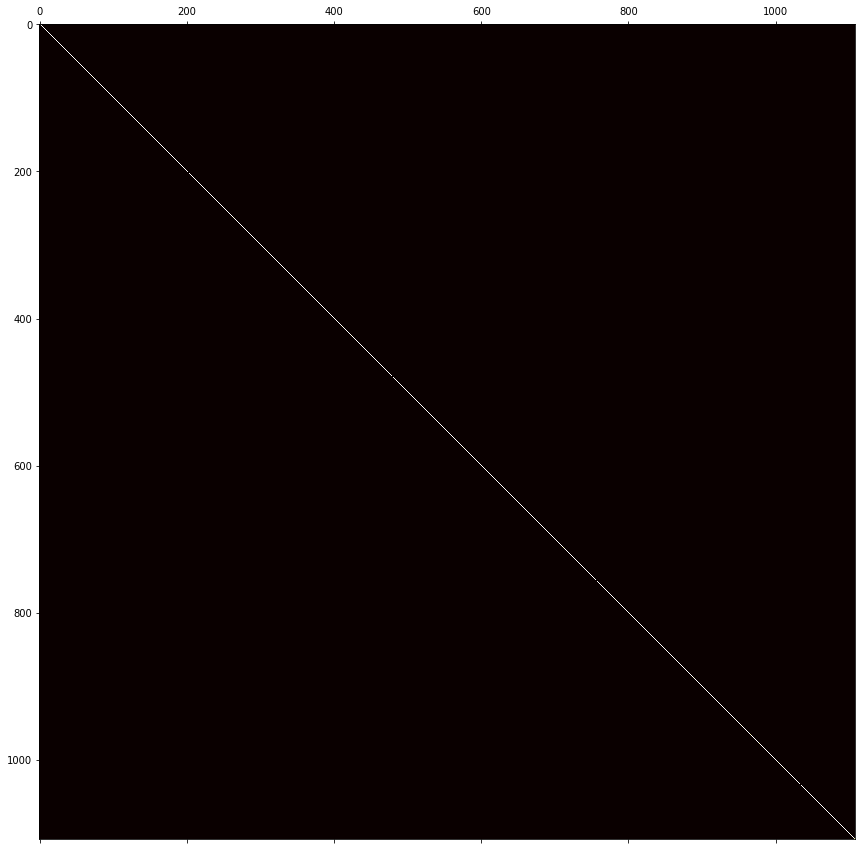

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [21]:
xq.max()

21.559402

In [22]:
faiss.normalize_L2(xq)

In [23]:
xq.max()

0.25155777

In [24]:
D_valid, I_valid = index.search(xq, k) # actual search

In [25]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [26]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [27]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[782 782 782 782 782]
 [343 343 343 343 343]
 [  6   6   6   6   6]
 [336 336 336 336 336]
 [295 295 295 295 295]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.6612148  0.65650845 0.6264291  0.590232   0.5895307 ]
 [0.63637406 0.6056385  0.5996834  0.59958804 0.57948035]
 [0.5637127  0.5229279  0.52239096 0.51499563 0.51354814]
 [0.5895052  0.5629396  0.559728   0.5582865  0.5521753 ]
 [0.6827079  0.5952791  0.57477164 0.5730411  0.5640929 ]]


In [28]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[427 109 611  23 427]
 [202 202 202 202 202]
 [824 824 824 824 824]
 [809 809 809 809 809]
 [314 314 314 314 314]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.5855088  0.5326246  0.5028292  0.4938646  0.47409028]
 [0.56228966 0.557937   0.5553614  0.5484478  0.5454118 ]
 [0.63926566 0.6212319  0.61685294 0.57333034 0.57318616]
 [0.65355515 0.6308887  0.63018584 0.6168045  0.6140156 ]
 [0.7056942  0.6857219  0.64875346 0.6482038  0.63957465]]


In [29]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [30]:
I_valid[:,0]

array([782, 343,   6, ..., 824, 809, 314])

In [31]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [32]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

6172

In [33]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.3988110622899974

In [34]:
valid_correct = np.equal(I_valid[:,0], yq)

In [35]:
valid_correct

array([False, False, False, ...,  True, False, False])

In [36]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [37]:
cm = confusion_matrix(I_valid[:,0], yq)

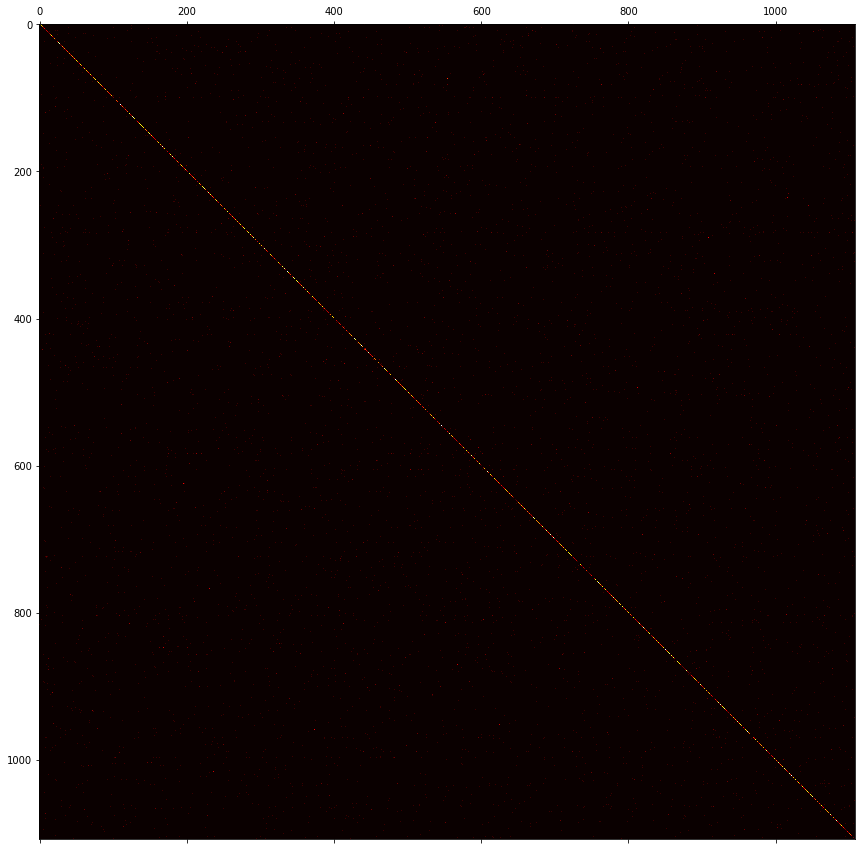

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [39]:
xq_test = np.load('pred/feats_test.npy')

In [40]:
xq_test.max()

25.078474

In [41]:
faiss.normalize_L2(xq_test)

In [42]:
xq_test.max()

0.2664354

In [43]:
D_test, I_test = index.search(xq_test, k) # actual search

In [44]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [45]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[1047 1047 1047 1047 1047]
 [ 768  768  768  768  768]
 [ 178  178  178  178  178]
 [ 249  249  249  249  249]
 [1005 1005 1005 1005 1005]]
[[0.7791482  0.7702527  0.7645202  0.76376116 0.7505355 ]
 [0.58851904 0.582553   0.5525055  0.54748243 0.5456923 ]
 [0.66725266 0.666757   0.66079134 0.6598299  0.659681  ]
 [0.68922    0.68085444 0.67707294 0.66999304 0.6597363 ]
 [0.6266215  0.6147987  0.5902128  0.5895926  0.5556117 ]]


In [46]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[557 557 557 557 557]
 [557 557 557 557 557]
 [755 755 755 755 755]
 [524 524 524 524 524]
 [557 557 557 557 557]]
[[0.58343846 0.57672507 0.57490575 0.545089   0.54130965]
 [0.7466154  0.7100834  0.7003038  0.68615246 0.68381333]
 [0.58399695 0.5426338  0.5424469  0.542212   0.54217476]
 [0.6371152  0.6363303  0.6095049  0.604555   0.5990224 ]
 [0.7429409  0.7031039  0.69343996 0.6922306  0.6905937 ]]


In [47]:
I_test[2]

array([178, 178, 178, 178, 178])

In [48]:
np.unique(I_test[2], return_counts=True)

(array([178]), array([5]))

In [49]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [50]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)